In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import os
import cv2  #OpenCV for image loading
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, UpSampling2D, Dense, Flatten, Reshape, Input,Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models

In [6]:
IMG_SIZE = (256, 256)  # Adjust this if needed
dataset_path = r"C:\Users\seela\dataset\brain" # Your dataset folder path

images = []
# Walk through the dataset directory to get all image files
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Adjust image extensions if necessary
            img_path = os.path.join(root, file)

            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, IMG_SIZE)
                img = img / 255.0  # Normalize
                images.append(img)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

print(f"Loaded {len(images)} images successfully!")

Loaded 90 images successfully!


In [8]:
def residual_block(x, filters):
    """A simple ResNet block with two convolutional layers."""
    res = Conv2D(filters, kernel_size=3, padding="same")(x)
    res = BatchNormalization()(res)
    res = LeakyReLU()(res)

    res = Conv2D(filters, kernel_size=3, padding="same")(res)
    res = BatchNormalization()(res)

    return Add()([x, res])  # Skip connection resnet concept

In [10]:
def build_generator():
    """Generator for CycleGAN using ResNet-based architecture."""
    input_layer = Input(shape=(256, 256, 1))  # Grayscale MRI input

    # Initial Convolution
    x = Conv2D(64, kernel_size=7, padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Residual Blocks
    for _ in range(6):
        x = residual_block(x, 64)

    # Upsampling
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Output Layer (CT Image)
    x = Conv2D(1, kernel_size=7, activation="tanh", padding="same")(x)  # Grayscale CT output

    model = Model(input_layer, x, name="Generator")
    return model

# Create and summarize the model
generator = build_generator()
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │           3,200 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256, 256, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 256, 256, 64)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256, 256, 64)      │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 256, 256, 64)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ leaky_re_lu_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 256, 256, 64)      │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256, 256, 64)      │               0 │ leaky_re_lu[0][0],         │
│                               │                           │                 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 256, 256, 64)      │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 256, 256, 64)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ leaky_re_lu_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 256, 256, 64)      │             25

 Total params: 489,985 (1.87 MB)

 Trainable params: 488,193 (1.86 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [11]:
#PatchGAN-Based)
def build_discriminator():
    """PatchGAN Discriminator for CycleGAN"""
    input_layer = Input(shape=(256, 256, 1))  # Grayscale MRI or CT input

    # Convolutional layers (PatchGAN)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # PatchGAN output (not a single value, but a feature map)
    x = Conv2D(1, kernel_size=4, strides=1, padding="same", activation="sigmoid")(x)

    model = Model(input_layer, x, name="Discriminator")
    return model

# Create and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
discriminator.summary()


C:\Users\seela\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 64)        │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,766,273 (10.55 MB)

 Trainable params: 2,764,481 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [12]:
# Function to preprocess the image
def preprocess_image(image_path):
    """
    Loads an image, converts it to grayscale (if needed),
    resizes it to (256, 256, 1), and normalizes pixel values to [-1, 1].
    """
    # Load image (grayscale or RGB)
    img = load_img(image_path, target_size=(256, 256))  # Resize to 256x256
    img = img_to_array(img)  # Convert to NumPy array

    # Convert to grayscale if the image has 3 channels (RGB)
    if img.shape[-1] == 3:  # If RGB, take mean across channels
        img = np.mean(img, axis=-1, keepdims=True)

    # Normalize pixel values to [-1, 1]
    img = (img / 127.5) - 1  # Convert range from [0,255] to [-1,1]

    return img


In [13]:
# Function: Load a Dataset (MRI or CT)
def load_dataset(image_folder):
    """
    Loads all images from a folder and preprocesses them into a TensorFlow dataset.
    """
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]

    # Preprocess all images
    images = [preprocess_image(img_path) for img_path in image_paths]

    # Convert list to TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(np.array(images))

    return dataset

In [18]:
# Define CycleGAN loss functions
def cycle_loss(real_image, reconstructed_image):
    return tf.reduce_mean(tf.abs(real_image - reconstructed_image))

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [20]:
# Initialize models
generator = build_generator()
discriminator = build_discriminator()

generator.compile(loss=generator_loss, optimizer=Adam(0.0002, 0.5))
discriminator.compile(loss=discriminator_loss, optimizer=Adam(0.0002, 0.5))

In [21]:
# Load MRI & CT Datasets
MRI_DATASET_PATH = r"C:\Users\seela\dataset\brain"# Example path, replace it with your actual path
CT_DATASET_PATH = r"C:\Users\seela\dataset\brain" # Example path, replace it with your actual CT path

# Load MRI and CT datasets
mri_dataset = load_dataset(MRI_DATASET_PATH)
ct_dataset = load_dataset(CT_DATASET_PATH)

# Take a specific image index, e.g., the 5th image (index 4)
specific_index = 7

mri_images = list(mri_dataset.as_numpy_iterator())  # Convert dataset to a list
ct_images = list(ct_dataset.as_numpy_iterator())

print("MRI Image Shape:", mri_images[specific_index].shape)
print("CT Image Shape:", ct_images[specific_index].shape)



MRI Image Shape: (256, 256, 1)
CT Image Shape: (256, 256, 1)


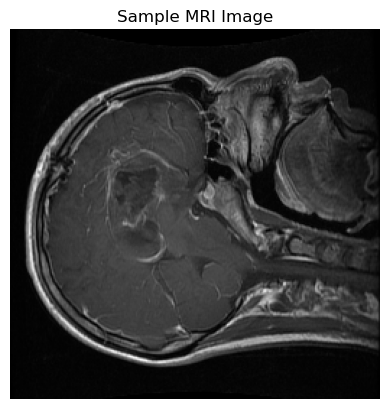

In [22]:
mri_images = next(iter(mri_dataset.batch(1)))
mri_image = mri_images.numpy().squeeze()  # Convert tensor to numpy array

# Display MRI image
plt.imshow(mri_image, cmap='gray')
plt.axis('off')
plt.title("Sample MRI Image")
plt.show()

In [24]:
def train_gan(epochs, batch_size, mri_dataset):
    """
    Trains the CycleGAN model to convert MRI images to synthetic CT images.
    """
    for epoch in range(epochs):
        for real_mri in mri_dataset.batch(batch_size):

            # Generate fake CT images
            fake_ct = generator.predict(real_mri)

            # Train the discriminator on real and fake CT images
            d_loss_real = discriminator.train_on_batch(fake_ct, np.ones((batch_size, 1)))  # Fake labeled as real
            d_loss_fake = discriminator.train_on_batch(real_mri, np.zeros((batch_size, 1)))  # Real labeled as fake
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator via GAN model
            g_loss = gan.train_on_batch(real_mri, np.ones((batch_size, 1)))  # Try to fool the discriminator

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

    print("Training complete!")

C:\Users\seela\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 118 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


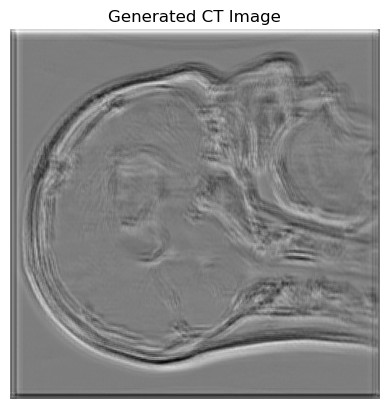

In [25]:
# Save the trained generator model in the recommended Keras format
generator.save("generator_model.keras")

# Load the trained generator model
generator = load_model("generator_model.keras",
                        custom_objects={'generator_loss': generator_loss}) # Pass custom objects

# Function to generate and display a synthetic CT image
def generate_synthetic_ct(generator, mri_dataset):
    """
    Generates and displays a synthetic CT image using the trained generator model.
    """
    # Get a single MRI image from the dataset
    new_mri_image = next(iter(mri_dataset.batch(1)))  # Take one image
    new_mri_image = new_mri_image.numpy()  # Convert tensor to NumPy array

    # Generate a synthetic CT image
    synthetic_ct = generator.predict(new_mri_image)

    # Display the new synthetic CT image
    plt.imshow(synthetic_ct[0, :, :, 0], cmap='gray')  # Show first image, grayscale
    plt.axis('off')
    plt.title("Generated CT Image")
    plt.show()

# Call the function to generate and display the synthetic CT image
generate_synthetic_ct(generator, mri_dataset)

In [26]:
import tensorflow as tf

def generator_loss(fake_ct, real_ct):
    """
    Generator loss: Adversarial loss + L1 loss for better CT image quality.
    """
    adv_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_ct), fake_ct)
    l1_loss = tf.reduce_mean(tf.abs(real_ct - fake_ct))  # L1 loss (MAE)
    return adv_loss + 100 * l1_loss  # Scale L1 loss for sharper images


In [27]:
import numpy as np

def cycle_consistency_loss(real_image, reconstructed_image):
    """Compute Mean Absolute Error (L1 Loss)"""
    # Resize reconstructed_image to match real_image dimensions
    reconstructed_image = reconstructed_image[0, ..., 0]  # Remove batch and channel dimensions
    reconstructed_image = cv2.resize(reconstructed_image, (real_image.shape[1], real_image.shape[0])) # Resize using OpenCV

    return np.mean(np.abs(real_image - reconstructed_image))

# Example usage:
# Get a new MRI Image
new_mri_image = next(iter(mri_dataset.batch(1))).numpy()

# Generate a synthetic CT image using the generator
synthetic_ct_images = generator.predict(new_mri_image)

# Assuming mri_image is already defined from a previous cell
loss = cycle_consistency_loss(mri_image, synthetic_ct_images)
print("Cycle Consistency Loss:", loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Cycle Consistency Loss: 0.6971839


In [28]:
def mse_loss(real_image, reconstructed_image):
    """Compute Mean Squared Error"""
    # Resize reconstructed_image to match real_image dimensions
    reconstructed_image = reconstructed_image[0, ..., 0]  # Remove batch and channel dimensions
    reconstructed_image = cv2.resize(reconstructed_image, (real_image.shape[1], real_image.shape[0]))  # Resize using OpenCV

    return np.mean((real_image - reconstructed_image)**2)

# Example usage:
# Get a new MRI Image
new_mri_image = next(iter(mri_dataset.batch(1))).numpy()

# Generate a synthetic CT image using the generator
synthetic_ct_images = generator.predict(new_mri_image)

# Assuming mri_image is already defined from a previous cell
loss_mse = mse_loss(mri_image, synthetic_ct_images)
print("MSE Loss:", loss_mse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
MSE Loss: 0.5632084


In [36]:
import numpy as np
import cv2

def compute_discriminator_accuracy(discriminator, real_images, fake_images):
    """Calculate and print the accuracy of the discriminator."""

    # Ensure real images have correct shape
    real_images = real_images.reshape(1, 256, 256, 1)  # Reshape to match model input

    # Ensure fake images have correct shape
    fake_images = fake_images[0, ..., 0]  # Remove batch & extra channel dimensions
    fake_images = cv2.resize(fake_images, (256, 256))  # Resize to match real image size
    fake_images = fake_images.reshape(1, 256, 256, 1)  # Ensure correct shape

    # Get predictions (ensure it's numpy array)
    real_preds = discriminator.predict(real_images).flatten()  # Flatten for easier processing
    fake_preds = discriminator.predict(fake_images).flatten()  # Flatten as well

    # Debugging: Print raw prediction values
    print(f"Real Image Predictions: {real_preds}")
    print(f"Fake Image Predictions: {fake_preds}")

    # Calculate correct classifications
    real_correct = np.sum(real_preds > 0.5)  # Real images classified as real
    fake_correct = np.sum(fake_preds < 0.5)  # Fake images classified as fake
    total_samples = len(real_preds) + len(fake_preds)

    # Ensure no division by zero
    accuracy = (real_correct + fake_correct) / total_samples if total_samples > 0 else 0

    print(f"Discriminator Accuracy: {accuracy:.4f}")  # Print before returning
    return accuracy

# Example usage (replace with actual images)
real_image_sample = np.random.rand(256, 256, 1)  # Simulated real MRI/CT image
fake_image_sample = np.random.rand(1, 256, 256, 1)  # Simulated fake image from generator

# Call function
compute_discriminator_accuracy(discriminator, real_image_sample, fake_image_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Real Image Predictions: [0.49281937 0.4965015  0.49221167 ... 0.50170887 0.5034845  0.5009133 ]
Fake Image Predictions: [0.49279797 0.49694017 0.4978369  ... 0.50251704 0.50215274 0.49997833]
Discriminator Accuracy: 0.5010


0.5009765625

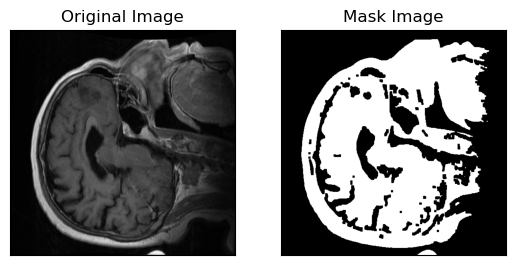

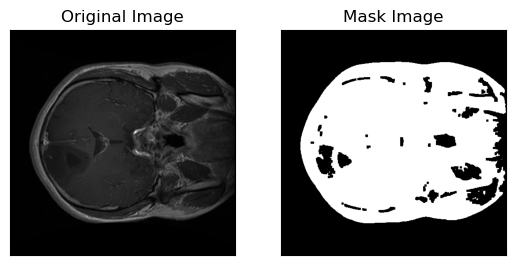

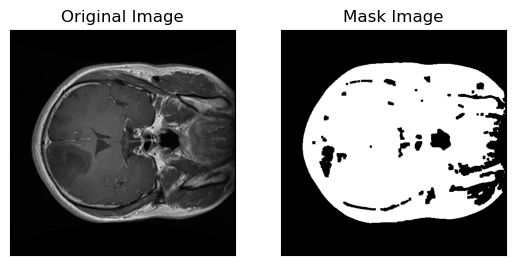

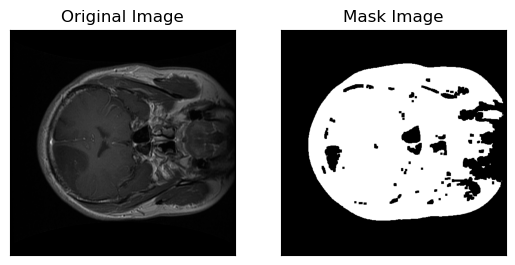

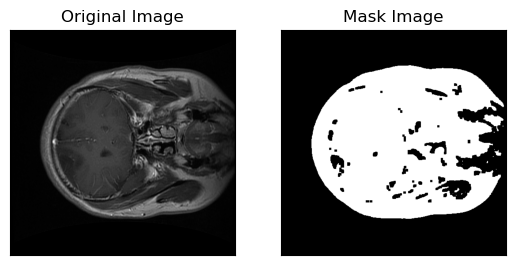

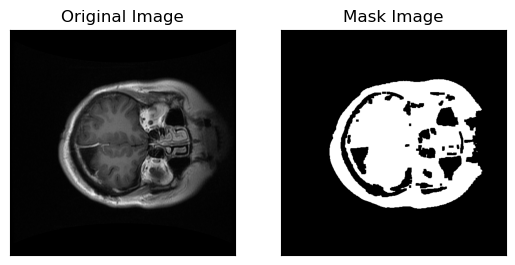

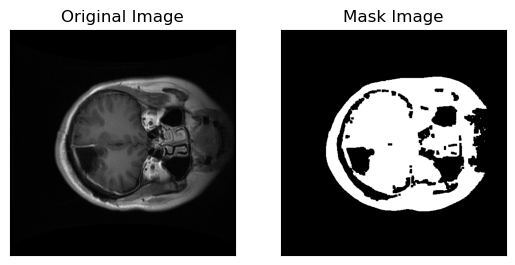

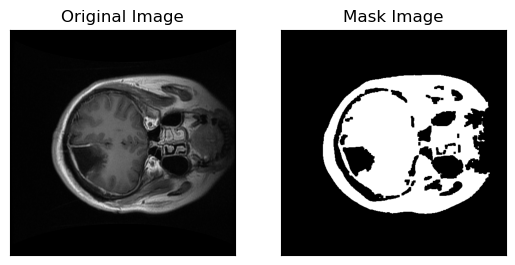

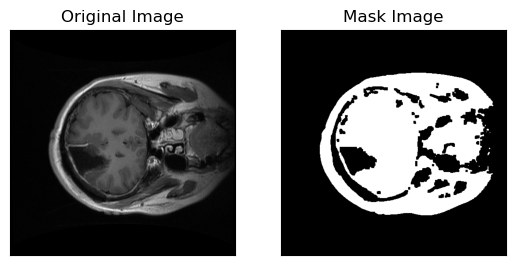

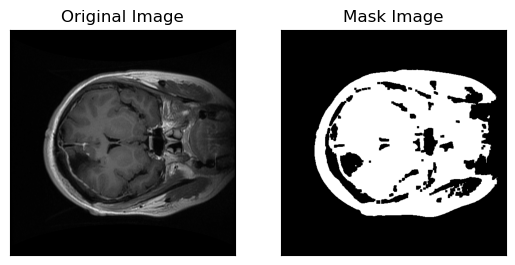

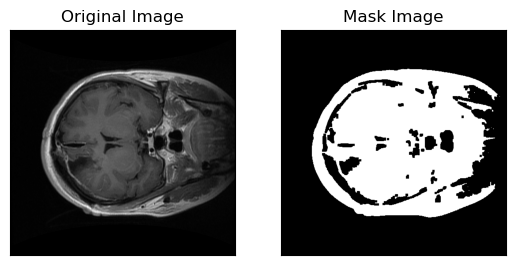

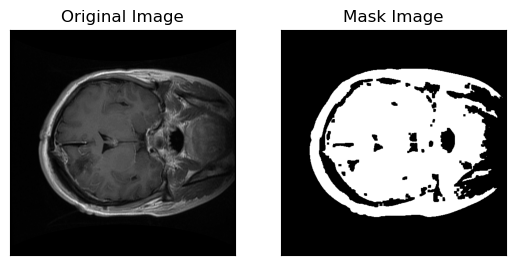

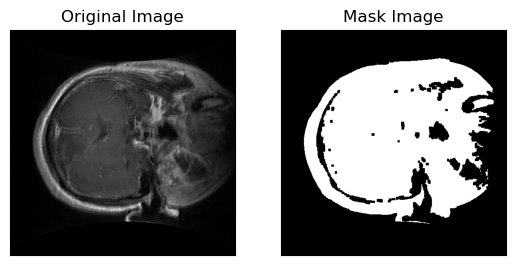

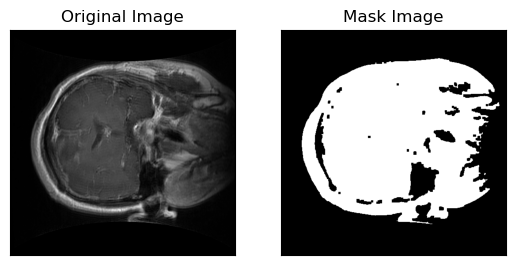

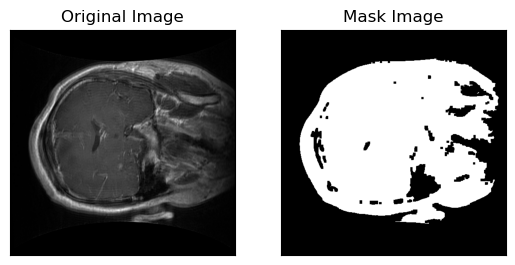

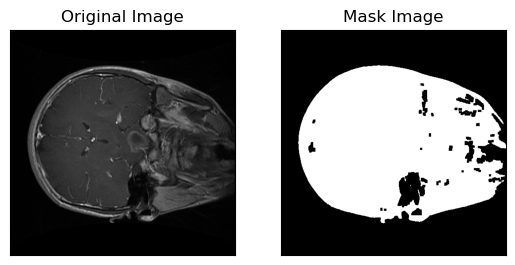

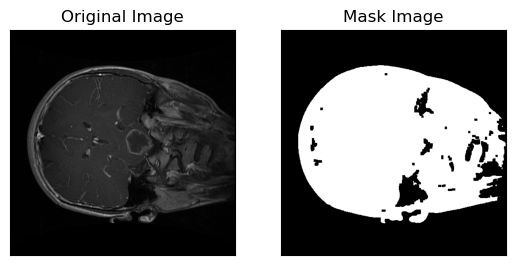

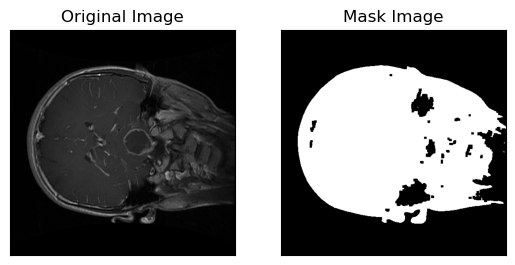

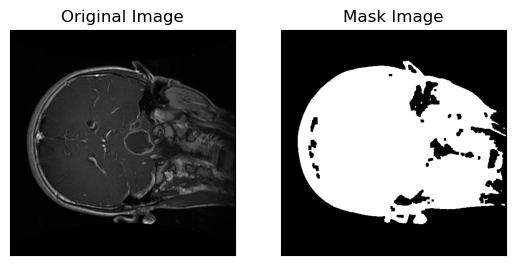

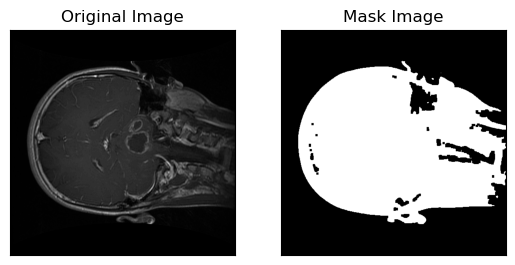

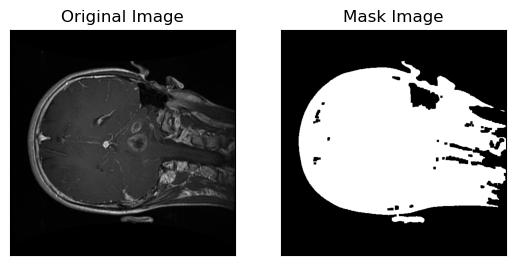

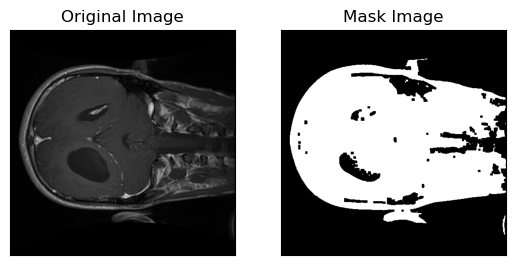

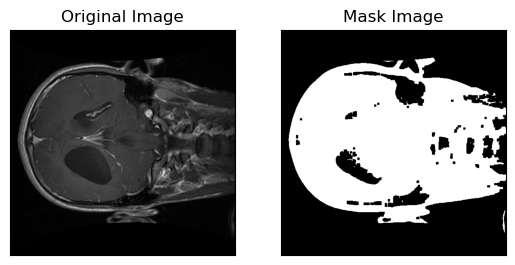

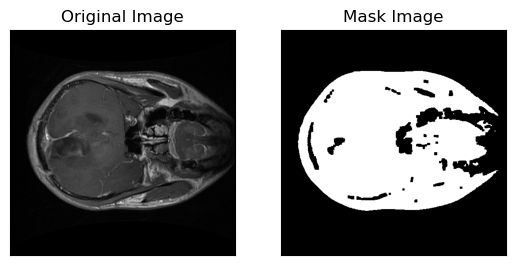

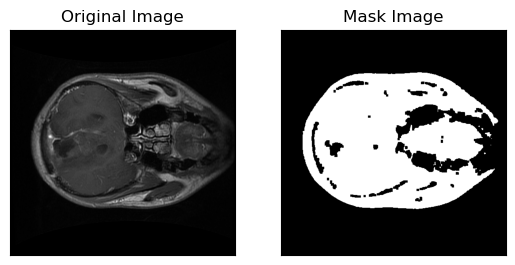

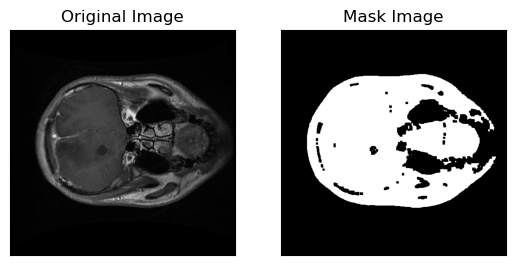

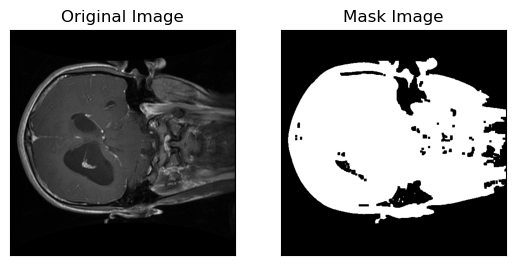

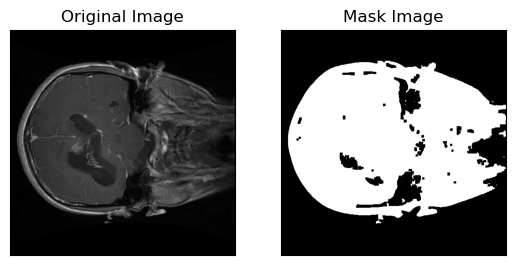

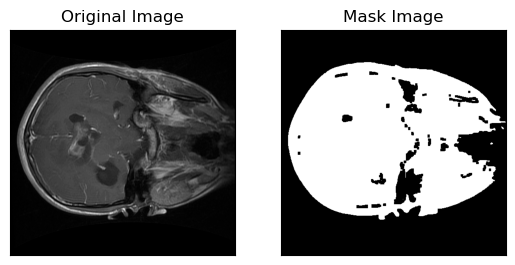

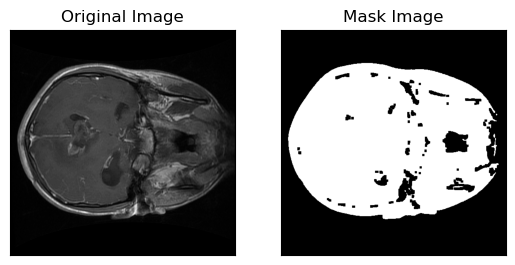

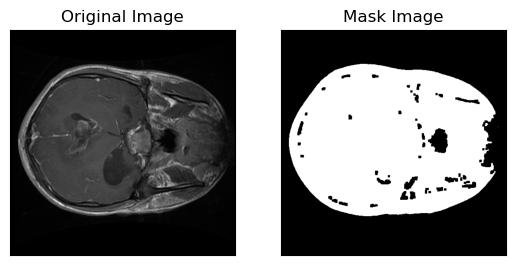

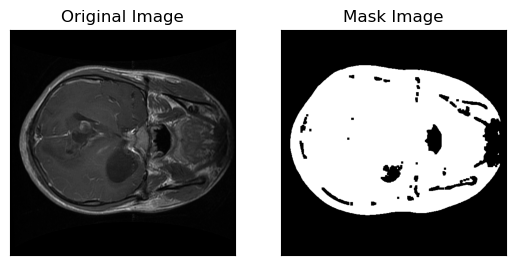

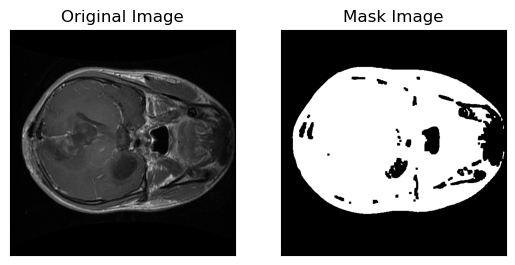

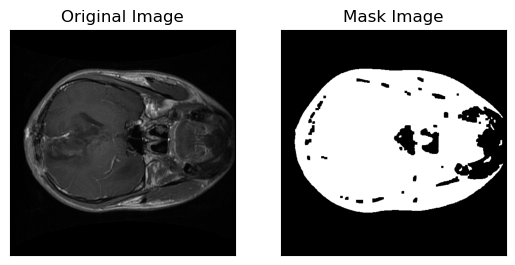

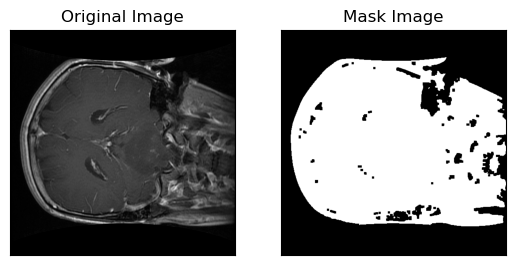

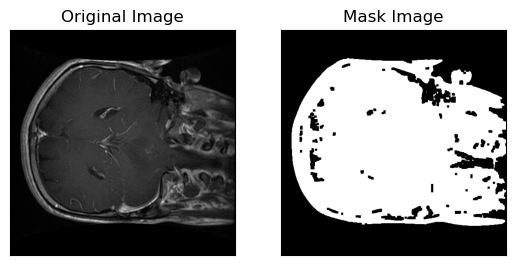

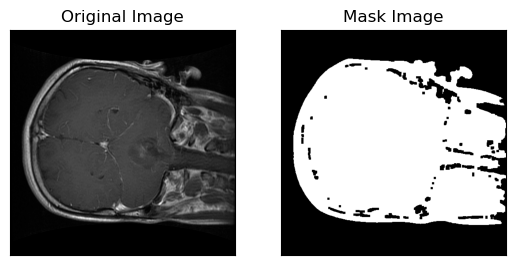

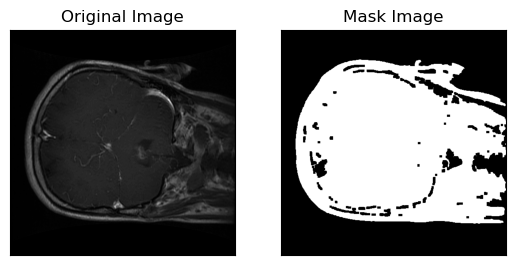

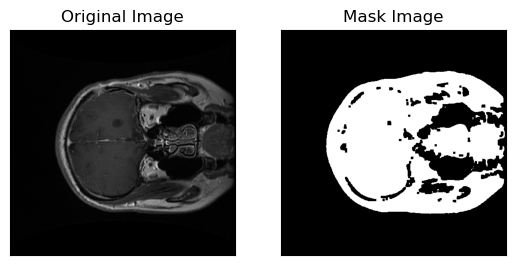

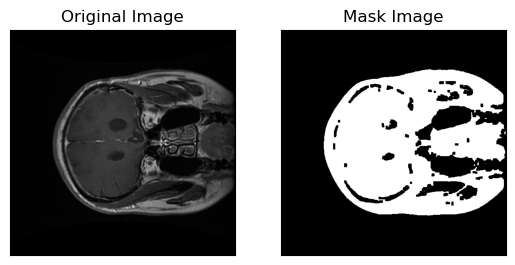

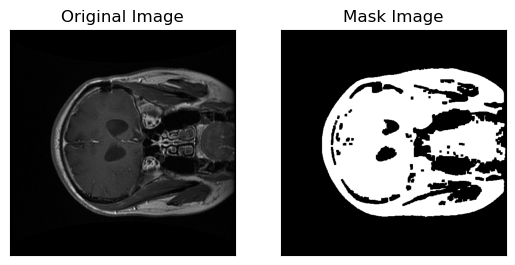

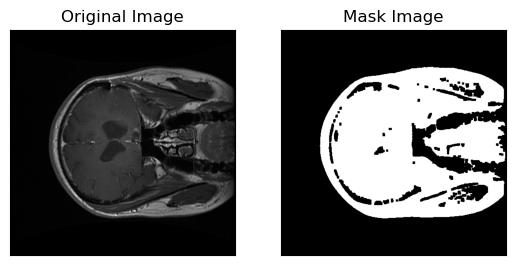

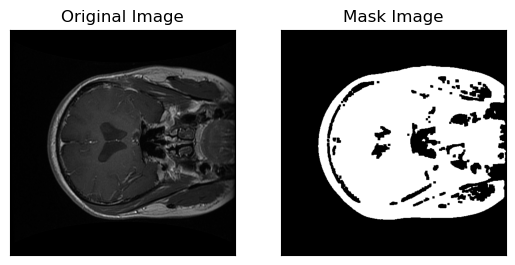

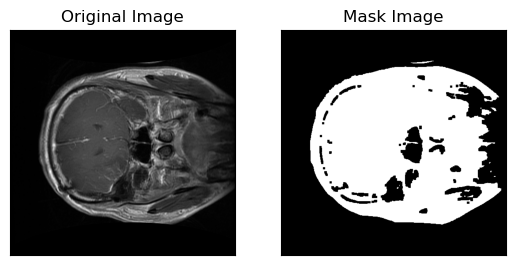

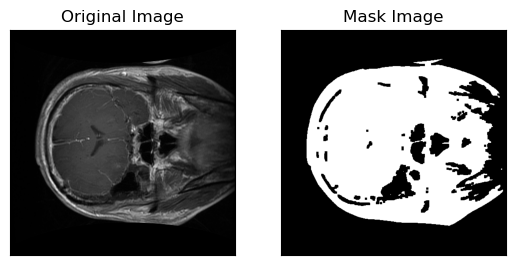

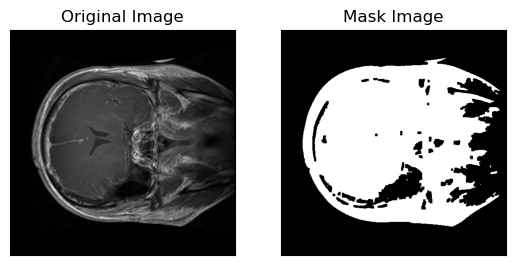

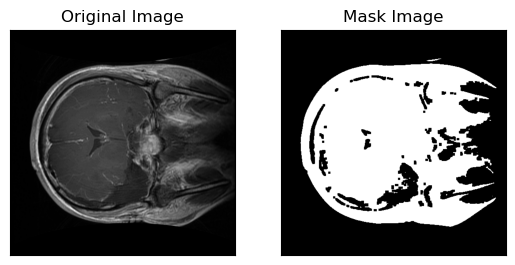

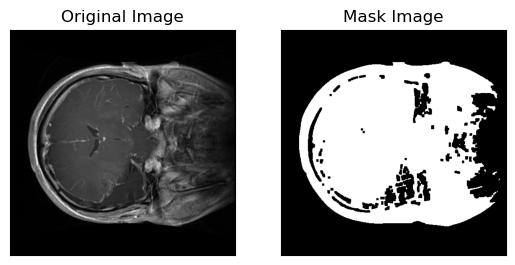

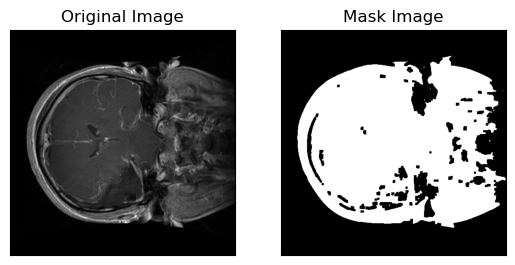

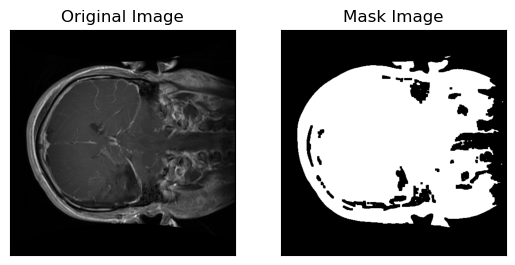

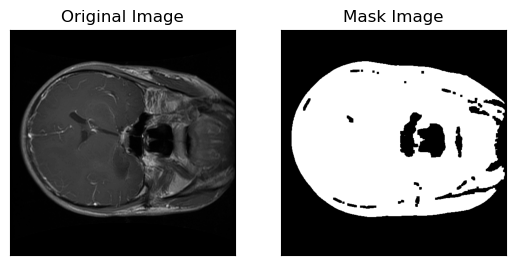

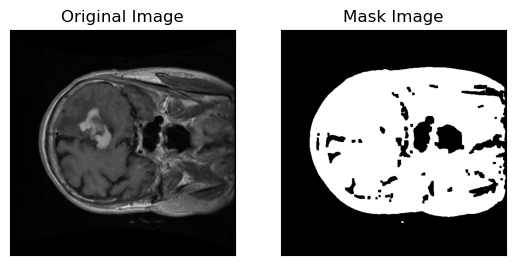

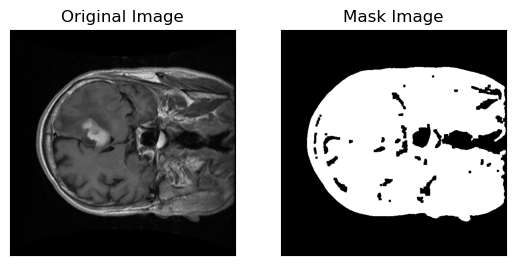

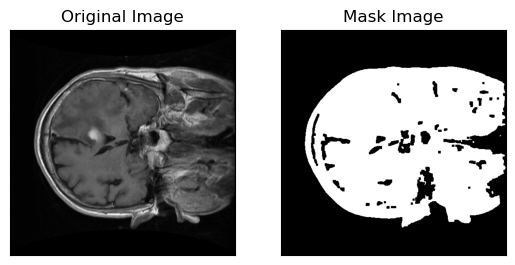

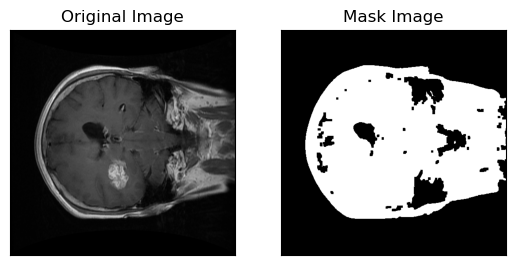

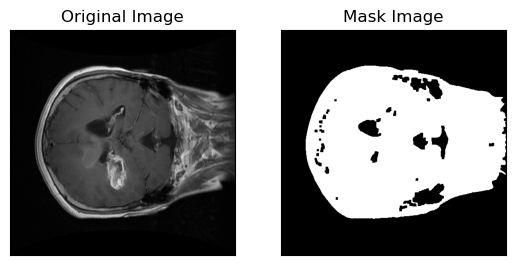

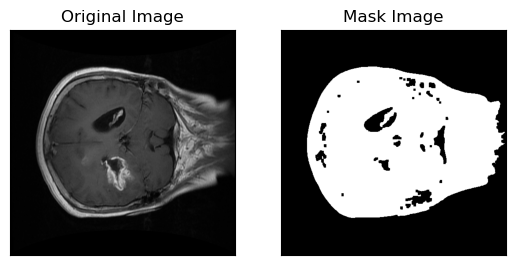

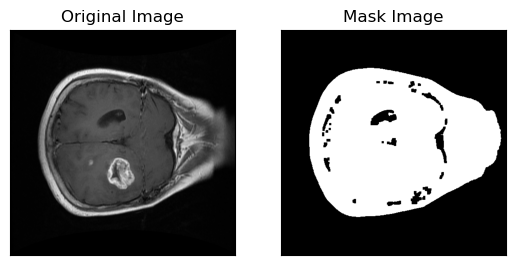

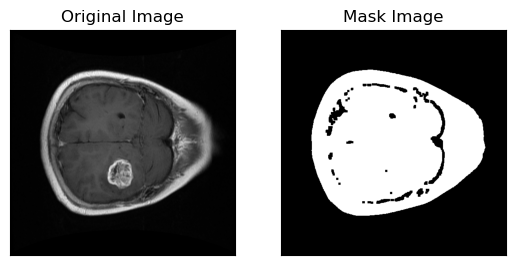

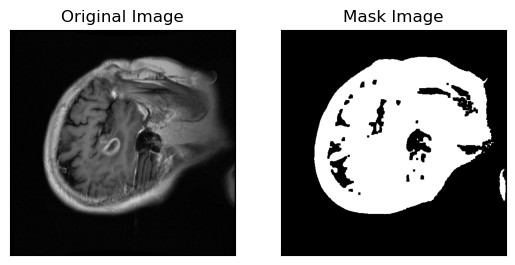

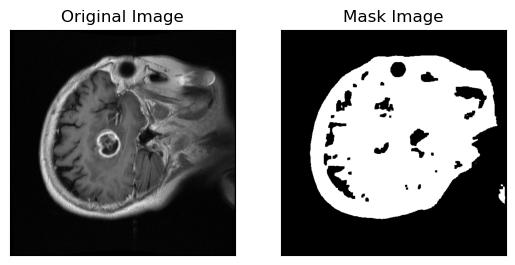

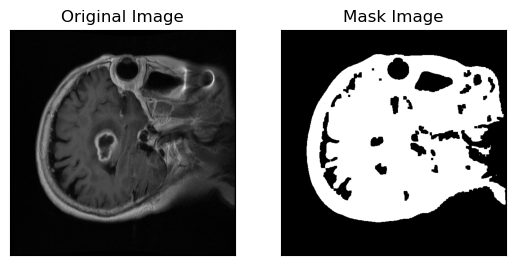

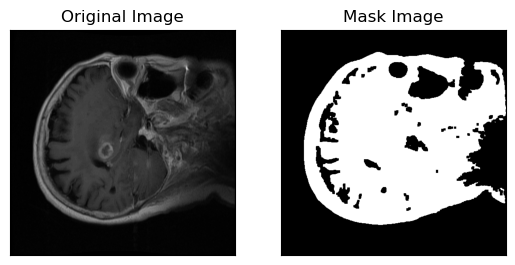

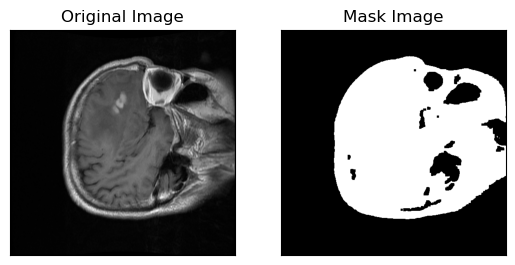

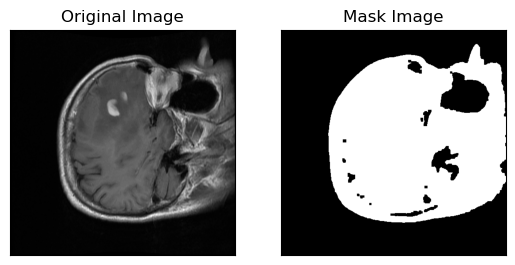

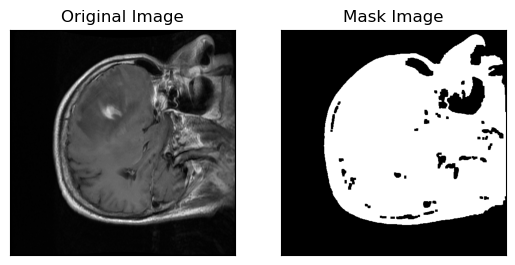

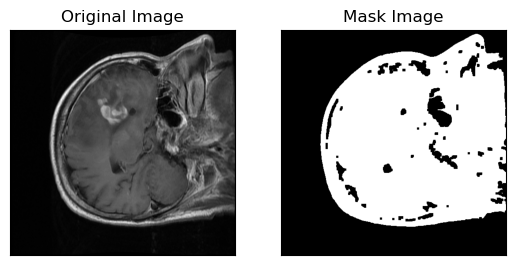

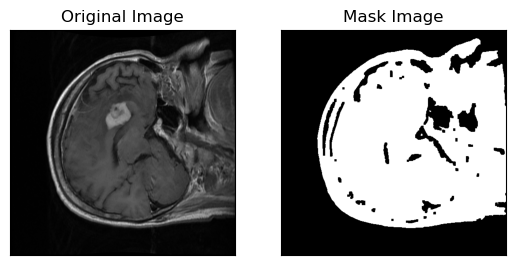

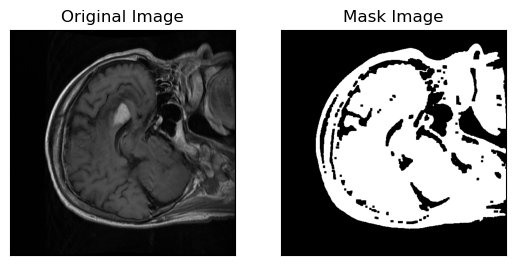

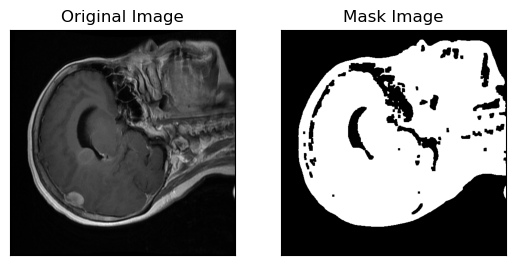

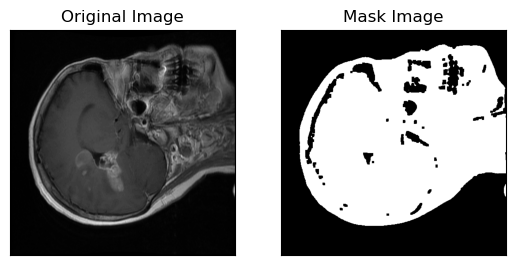

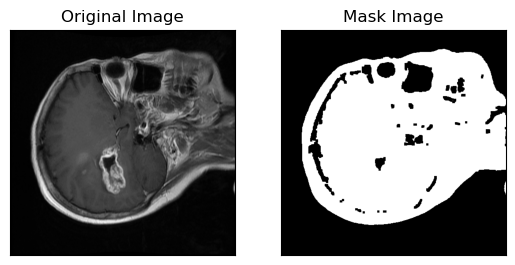

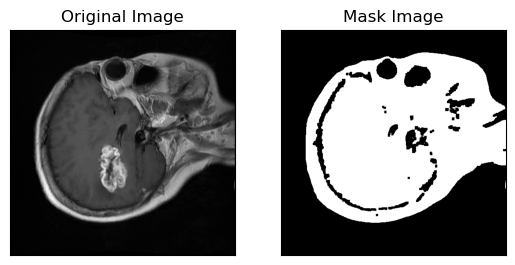

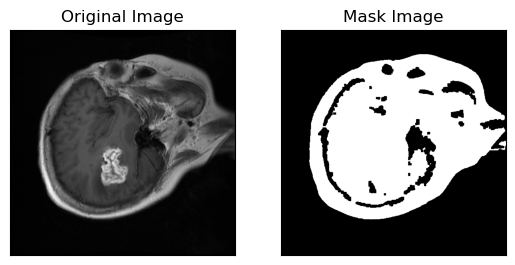

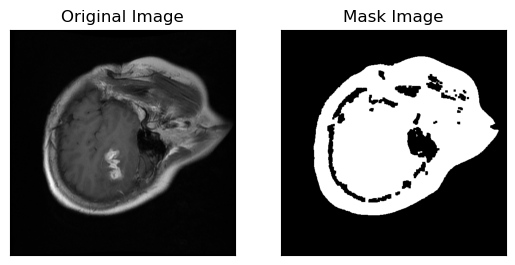

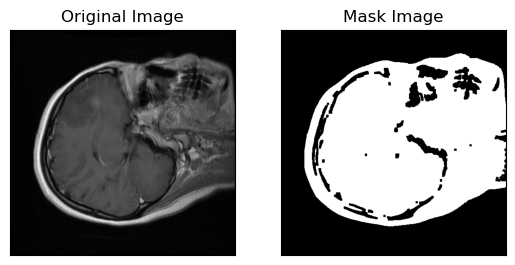

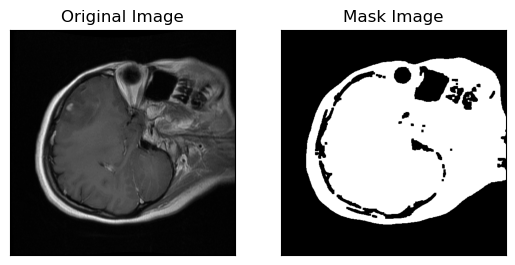

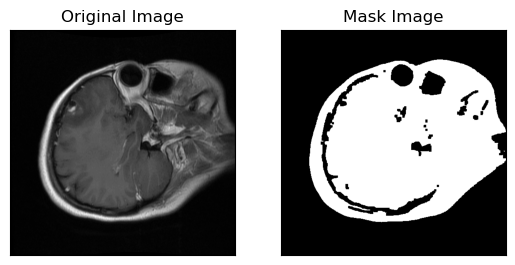

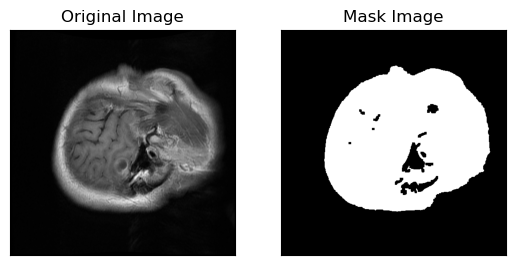

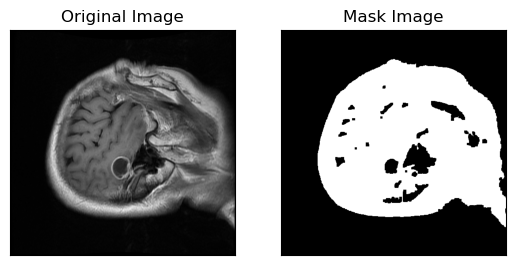

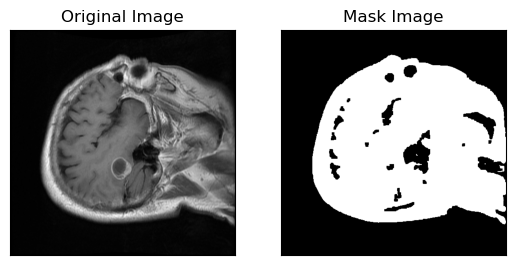

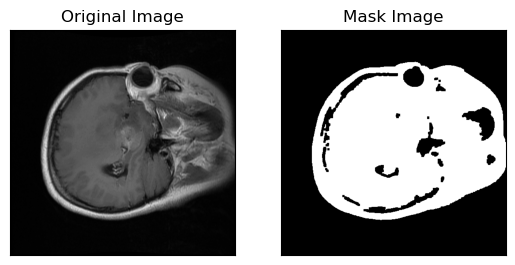

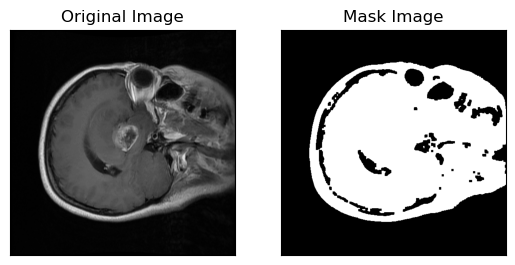

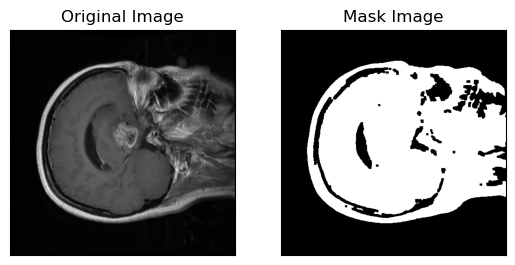

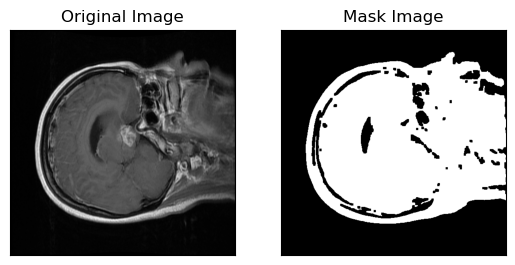

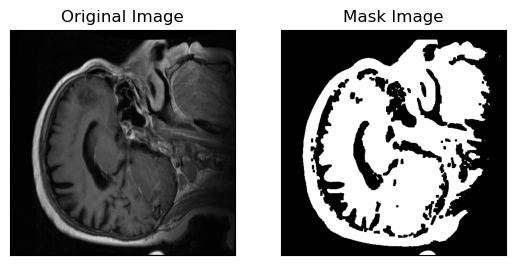

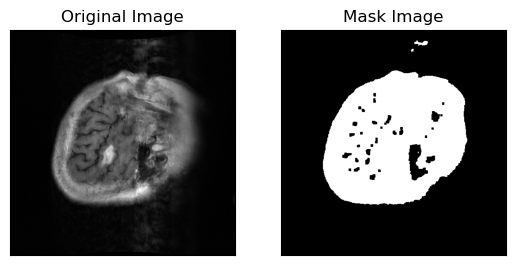

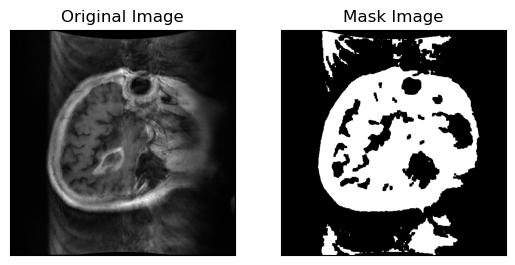

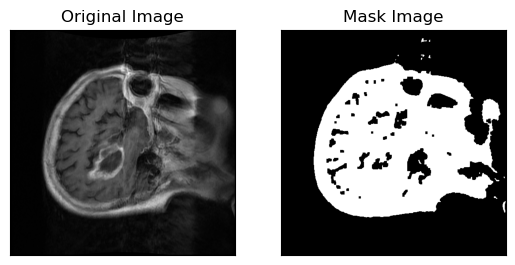

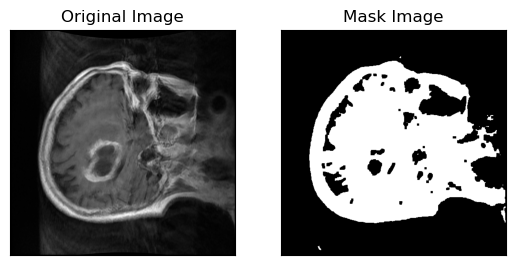

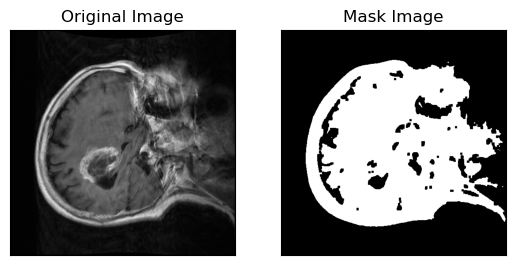

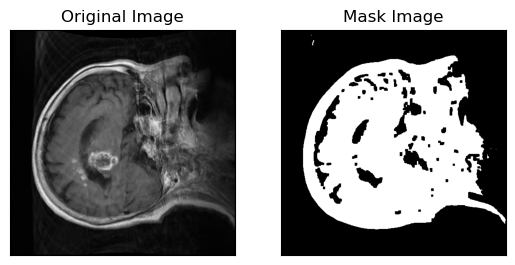

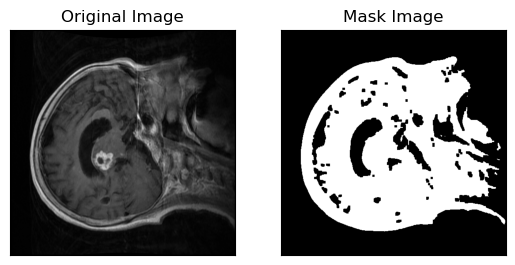

In [38]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Define path to your MRI images
mri_image_path = r"C:\Users\seela\dataset\glioma\tumor" # Example folder, change for your dataset

# Loop through each image in the folder
for filename in os.listdir(mri_image_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust for your file types
        # Read the image
        image = cv2.imread(os.path.join(mri_image_path, filename), cv2.IMREAD_GRAYSCALE)

        # Apply Otsu's Thresholding
        ret, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Apply morphological operations to refine the mask (e.g., dilation)
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        mask_filename = filename.split('.')[0] + "_mask.png"
        mask_folder = r"C:\Users\seela\dataset\glioma\tumor"  # New folder to save masks
        if not os.path.exists(mask_folder):
          os.makedirs(mask_folder)  # Create folder if not exists
          cv2.imwrite(os.path.join(mask_folder, mask_filename), mask)


        # Save or visualize the mask
        mask_filename = filename.split('.')[0] + "_mask.png"
        cv2.imwrite(os.path.join(mri_image_path, mask_filename), mask)

        # Optionally, display the images for verification
        plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray')
        plt.title("Original Image"), plt.xticks([]), plt.yticks([])

        plt.subplot(1, 2, 2), plt.imshow(mask, cmap='gray')
        plt.title("Mask Image"), plt.xticks([]), plt.yticks([])

        plt.show()

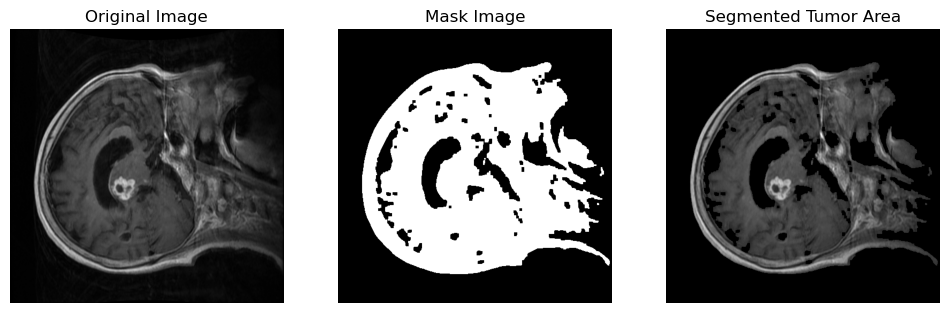

In [39]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

_, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

# Remove small noise using morphological opening
kernel = np.ones((3, 3), np.uint8)
cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

# Apply Bitwise AND to segment tumor region
segmented_image = cv2.bitwise_and(image, image, mask=cleaned_mask)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cleaned_mask, cmap='gray')
plt.title("Mask Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Tumor Area")
plt.axis('off')

plt.show()

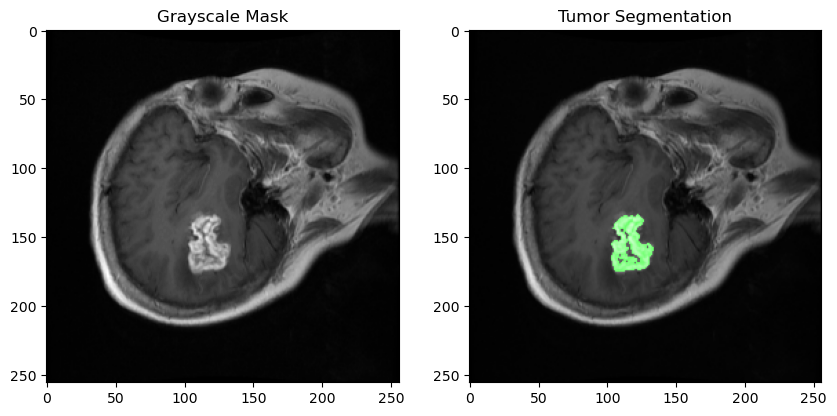

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Assuming 'images' is your list of loaded images
# Choose the specific image you want to work with (e.g., the first image)
image_to_segment = images[15]  

# Convert the image to grayscale if it's not already
if len(image_to_segment.shape) == 3:  # Check if it's a color image
    # Convert image to 8-bit unsigned integer before color conversion
    image_to_segment = (image_to_segment * 255).astype(np.uint8) 
    gray_image = cv2.cvtColor(image_to_segment, cv2.COLOR_BGR2GRAY)
else:
    gray_image = image_to_segment

# Create an RGB version of the grayscale image (for color mask)
brain_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

# Create an empty color mask
color_mask = np.zeros_like(brain_image)

# Threshold to select bright white tumor regions
tumor_mask = cv2.inRange(gray_image, 120, 255)  # Tumor intensity range

# Define coordinates (y_start:y_end, x_start:x_end)
selected_area = tumor_mask[100:190, 100:150]

# Apply green color only to the selected area
color_mask[100:190, 100:150][selected_area > 0] = [0, 255, 0]  # Green color for tumor

# Merge both brain image and tumor mask
final_image = cv2.addWeighted(brain_image, 0.9, color_mask, 1.0, 0)

# Display Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Grayscale Mask")
plt.imshow(gray_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Tumor Segmentation")
plt.imshow(final_image)
plt.show()